# Capstone Project: Spotify Popularity Prediction And Recommender

General Assembly DSI 19 Capstone Project Adrian Teng

## Executive Summary

In this project, it is splitted into three parts respectively:

- EDA(01_eda)
- Processing & Modelling(02_modelling)
- Clustering & Recommender(03_clustering_recommender)

In the second notebook, 02_modelling, Recursive Feature Elimination to do feature selection and gridsearch was done in another notebook to save time for the regression model to predict and find the casual effect relationship between variables. 

Regression Models: Linear Regression, RandomForestRegressor, AdaBoostRegressor, DecisionTreeRegressor will be used for accessment with the pre-processed data. They are also tested for R2-score, mean_squared_error, mean_absolute_error. 

### Content
- Section 3: Pre_processing
- Section 4: Feature Selection
- Section 5: Modelling
             


In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import time 
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

In [124]:
#load data
data = pd.read_csv('./datasets/data.csv')

In [125]:
df_new = pd.DataFrame(data)


## Section 3: Pre-processing

In [128]:
#function for preprocessing
def prepros(df_new):
    df_new = df_new.select_dtypes(np.number) #keep numercial 
    features= [col for col in df_new.columns if col not in ['popularity']] #all except 'popularity'
    X = df_new[features] 
    y = df_new['popularity']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.1)
    ss = StandardScaler() 
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    return X_train, X_test, y_train, y_test, features

In [129]:
X_train, X_test, y_train, y_test, features = prepros(df_new)

## Section 4: Features Selection

In [186]:
#rfe loop
high_score = 0
record=[]
nof=0 
score_list =[]
for i in range(1,14):
    model = LinearRegression()
    rfe = RFE(model,n_features_to_select = i)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    record.append(list(zip(features,rfe.support_,rfe.ranking_))) #append to record
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)  # append to score list
    if(score>high_score):    #only add if condition apply
        high_score = score
        nof = i
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 11
Score with 11 features: 0.758111


In [133]:
# ranking of each features
df_record = pd.DataFrame([[tup[2] for tup in rec] for rec in record], columns = features, index=list(range(1,14))).T
df_record

,1,2,3,4,5,6,7,8,9,10,11,12,13
valence,9,8,7,6,5,4,3,2,1,1,1,1,1
year,1,1,1,1,1,1,1,1,1,1,1,1,1
acousticness,3,2,1,1,1,1,1,1,1,1,1,1,1
danceability,5,4,3,2,1,1,1,1,1,1,1,1,1
duration_ms,13,12,11,10,9,8,7,6,5,4,3,2,1
energy,7,6,5,4,3,2,1,1,1,1,1,1,1
explicit,8,7,6,5,4,3,2,1,1,1,1,1,1
instrumentalness,2,1,1,1,1,1,1,1,1,1,1,1,1
key,14,13,12,11,10,9,8,7,6,5,4,3,2
liveness,6,5,4,3,2,1,1,1,1,1,1,1,1


'key' was ranked 14 and 'duration_ms' was ranked 3 and was recommended to be removed for the most optimal score.

In [143]:
#drop the lowest 2 ranking features
df_select = df_new.drop(columns =['key','duration_ms'])

In [144]:
#retrain in the function
X_train, X_test, y_train, y_test, features = prepros(df_select)

## Selection 2: Applying Regression Models

In [167]:
steps =  [ #list of pipeline steps for each model  
    [('lr', LinearRegression())],
    [('rfr',RandomForestRegressor(max_depth=20, n_estimators= 300, random_state=0))],
    [('dtr',DecisionTreeRegressor(random_state=0))],
    [('abr',AdaBoostRegressor(random_state=1))]
    ]



pipe_titles = ['lr', 'rfr', 'dtr', 'abr']

grid_results = pd.DataFrame(columns=['step','train_accuracy', 'test_accuracy', 'r2_score', 
                                     'mean_squared_error','mean_absolute_error'])

In [168]:
for i in (range(len(steps))):          
    pipe = Pipeline(steps=steps[i])         # configure pipeline for each model
    grid = pipe
    model_results = {}
    
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    
    print('Step: ',pipe_titles[i])
    model_results['step'] = pipe_titles[i]


    #Score the model on training set
    print(f"training score: {grid.score(X_train, y_train)}", '\n')
    model_results['train_accuracy'] = grid.score(X_train, y_train)
    
    #Score the model on test set
    print(f"test score: {grid.score(X_test, y_test)}", '\n')
    model_results['test_accuracy'] = grid.score(X_test, y_test)
    
    #R2 score the model on test set
    print(f"R2 score: {r2_score(y_test, y_pred)}", '\n')
    model_results['r2_score'] = r2_score(y_test, y_pred)
    
    #mean_squared_error the model on test set
    print(f"mean_squared_error: {mean_squared_error(y_test, y_pred)}", '\n')
    model_results['mean_squared_error'] = mean_squared_error(y_test, y_pred)
    
    #mean_absolute_error the model on test set
    print(f"mean_absolute_error: {mean_absolute_error(y_test, y_pred)}", '\n')
    model_results['mean_absolute_error'] = mean_absolute_error(y_test, y_pred)


    grid_results = grid_results.append(model_results, ignore_index=True)

Step:  lr
training score: 0.7530549771920028 

test score: 0.7581001273029934 

R2 score: 0.7581001273029934 

mean_squared_error: 115.63773446140532 

mean_absolute_error: 7.982060489455835 

Step:  rfr
training score: 0.9299693660798957 

test score: 0.8118101275743208 

R2 score: 0.8118101275743208 

mean_squared_error: 89.96222384599758 

mean_absolute_error: 6.6979087172985405 

Step:  dtr
training score: 0.9971449151588991 

test score: 0.6071101018161782 

R2 score: 0.6071101018161782 

mean_squared_error: 187.81695588429127 

mean_absolute_error: 9.245266137628143 

Step:  abr
training score: 0.6836098777066395 

test score: 0.6835410056881939 

R2 score: 0.6835410056881939 

mean_squared_error: 151.27995208988327 

mean_absolute_error: 10.009931575640014 



In [189]:
grid_results

,step,train_accuracy,test_accuracy,r2_score,mean_squared_error,mean_absolute_error
0,lr,0.753055,0.758100,0.758100,115.637734,7.982060
1,rfr,0.929969,0.811810,0.811810,89.962224,6.697909
2,dtr,0.997145,0.607110,0.607110,187.816956,9.245266
3,abr,0.683610,0.683541,0.683541,151.279952,10.009932


Even though DecisionTree got the highest Train score, but RandomForest have a higher predicted score with lower errors.

### RandomForestRegressor R2 score plotting

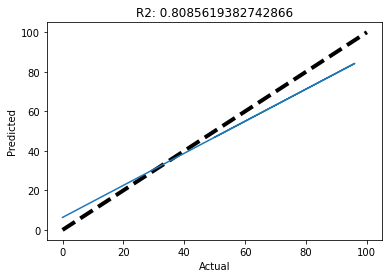

In [185]:
fig, ax = plt.subplots()
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw =4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

y_test, y_predicted = y_test.reshape(-1,1), y_pred_rfr.reshape(-1,1)
ax.plot(y_test, LinearRegression().fit(y_test, y_pred_rfr).predict(y_test))
ax.set_title('R2: '+ str(r2_score(y_test, y_predicted)))
plt.show()